In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('mythical.txt', 'r').read().splitlines()
words[:8]

['frostwyrm',
 'emberdrake',
 'thundergriffin',
 'shadowfenrir',
 'luminara serpent',
 'crystalbeast',
 'nebula phoenix',
 'specterwolf']

In [3]:
len(words)

397

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
lenMap = len(stoi)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append # Just like a rolling window

  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:

X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([5495, 3]), torch.int64, torch.Size([5495]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  7],
        [ 0,  7, 18],
        ...,
        [ 6, 14, 18],
        [14, 18, 10],
        [18, 10, 18]])

In [8]:
Y

tensor([ 7, 18, 15,  ..., 10, 18,  0])

In [9]:
# Creating look up table C of dimension 2.
C = torch.randn((lenMap,2))

#### How table look up works

In [10]:
C[5]

tensor([2.7450, 0.0264])

In [11]:
C[torch.tensor([5,6,7,7,7,7,7])] #Rmb that need to change to float to multiply anything with @ C

tensor([[ 2.7450,  0.0264],
        [ 0.1212, -0.7517],
        [ 1.3292, -1.4969],
        [ 1.3292, -1.4969],
        [ 1.3292, -1.4969],
        [ 1.3292, -1.4969],
        [ 1.3292, -1.4969]])

In [12]:
# C : 26,2  
# X : 5495, 3
# We are looking up 5495 examples, which each contain 3 characters, and each character will have 2 embeds_?
C[X].shape 

torch.Size([5495, 3, 2])

In [13]:
X[1,2]

tensor(7)

In [14]:
C[X][1,2]


tensor([ 1.3292, -1.4969])

In [15]:
C[7]

tensor([ 1.3292, -1.4969])

In [16]:
C[X][1] # Contains the 2 embeds of all 3 characters of the 1-index example

tensor([[ 0.5296, -0.4894],
        [ 0.5296, -0.4894],
        [ 1.3292, -1.4969]])

In [17]:
emb = C[X] #embed
emb.shape 
# 5495 examples / training data
# 3 previous characters
# 2 "dimensions" worth of complexity?

torch.Size([5495, 3, 2])

#### Utilizing torch's various functions for tensor manipulation

In [18]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
# use torch.unbind(emb, 1) instead, as if we were to change the block size to eg: 5, then we need to rewrite this
# concatenate at dimension 1 not 0!

tensor([[ 0.5296, -0.4894,  0.5296, -0.4894,  0.5296, -0.4894],
        [ 0.5296, -0.4894,  0.5296, -0.4894,  1.3292, -1.4969],
        [ 0.5296, -0.4894,  1.3292, -1.4969,  0.5827,  0.6361],
        ...,
        [ 0.1212, -0.7517, -0.7228, -0.4170,  0.5827,  0.6361],
        [-0.7228, -0.4170,  0.5827,  0.6361,  0.4531,  0.8014],
        [ 0.5827,  0.6361,  0.4531,  0.8014,  0.5827,  0.6361]])

In [19]:
emb[:, 1, :] # Note how it concatenates! 2 + 2 + 2 = 6 , 2 from each 

tensor([[ 0.5296, -0.4894],
        [ 0.5296, -0.4894],
        [ 1.3292, -1.4969],
        ...,
        [-0.7228, -0.4170],
        [ 0.5827,  0.6361],
        [ 0.4531,  0.8014]])

In [20]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([5495, 6])

In [21]:
# A dynamic way to do it

torch.cat(torch.unbind(emb, 1), 1).shape

# However, all these concat creates new instances and uses memory. Better to instead use view

torch.Size([5495, 6])

#### x.view functionality

In [22]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [23]:
a.shape

torch.Size([18])

In [24]:
a.view(9,2)
#a.view(3,3,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [25]:
a.storage

<bound method Tensor.storage of tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])>

In [26]:
emb.shape

torch.Size([5495, 3, 2])

In [27]:
emb.view(emb.shape[0], 6) == torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
#emb.shape[0] can be swapped for -1, pytorch will infer and do the rest

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

### Once we are sure everything works

#### Initialize our Weights and Biases

In [28]:
W1 = torch.randn((6,100)) #6 because we have 3 previous chars and 2 embedded for each
b1 = torch.randn(100) # 100 biases for 100 neurons

In [29]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
h

tensor([[-0.9755, -0.4184,  0.9313,  ..., -0.2808, -0.8976, -0.7103],
        [-0.9404,  0.9468,  0.9813,  ..., -0.5729, -0.9655, -0.0229],
        [-0.9932, -0.9996,  0.9981,  ...,  0.6625, -0.9080, -0.9971],
        ...,
        [-0.8962, -0.9997,  0.9496,  ...,  0.3021,  0.1754, -0.9218],
        [ 0.9941, -0.9388,  0.7308,  ..., -0.2215, -0.6570,  0.7874],
        [ 0.7369, -0.8985,  0.9821,  ...,  0.3505,  0.3658,  0.7896]])

##### Checking if addition of W1 and b1, has correct broadcasting

In [30]:
(emb.view(emb.shape[0],6) @ W1).shape

torch.Size([5495, 100])

In [31]:
b1.shape

torch.Size([100])

In [32]:
# 5495, 100
#    1, 100

# Align to right
# Either 1 or non-existent
# In this case correct as all the biases will be added to the corresponding elements along the 1st dimension
# pytorch basically extends the b1 array from 1 row to 5495 row, duplicating the content and does element wise addition

#### Creating final layer

In [33]:
W2 = torch.randn((100,lenMap)) #6 because we have 3 previous chars and 2 embedded for each
b2 = torch.randn(lenMap) # lenMap biases for lenMap Neurons, in this case we have 26 characters!

In [34]:
logits = h @ W2 + b2
logits.shape

torch.Size([5495, 26])

In [35]:
# exponentiate our logits to get our fake counts
counts = logits.exp() 

In [36]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([5495, 26])

In [37]:
#Normalized
prob[0].sum()

tensor(1.0000)

##### Grabbing our model's results of the corresponding Y(answer)

In [38]:
prob[torch.arange(prob.shape[0]), Y]

tensor([5.4203e-07, 4.0282e-07, 1.5054e-03,  ..., 1.4809e-12, 4.0753e-19,
        2.6346e-09])

#### Finding our nll

In [39]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(18.3936)

## Made respectable

In [40]:
X.shape, Y.shape

(torch.Size([5495, 3]), torch.Size([5495]))

In [55]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((lenMap,2), generator = g) # look up table
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, lenMap), generator = g)
b2 = torch.randn(lenMap, generator = g)
parameters = [C,W1,b1,W2,b2]

In [56]:
sum(p.nelement() for p in parameters) # number of parameters in total

3378

In [57]:
for p in parameters:
    p.requires_grad = True

##### FInding the best learning rate

In [58]:
lre = torch.linspace(-3, 0, 1000 ) # Learning rate exponent. Creates 1000 nums btwn -3 and 0
lrs = 10**lre # so we are stepping in bewteen 10^-3 and 0^-3 which is 0.001 and 1
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [60]:
lri = []
lossi= []

for i in range(100000):

    # MINIBATCH CONSTRUCT
    # Generate 32 numbers btwn 0 and X.shape[0]
    # Notice that it takes alot of time to calculate. Instead we should do forward and backward passes from mini batches
    ix = torch.randint(0, X.shape[0], (32,))
    
    # FORWARD PASS
    emb = C[X[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # 32, 100
    logits = h @ W2 + b2 # (32, lenMap)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #prob[0].sum()
    #loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
    # Similar to classification and already has inbuilt function CROSS ENTROPY
    # Much more efficient *clustered mathematical operations*
    # Avoids unbehaved very positive logits as well, where when exponentiated gives nan (run out of numbers to represent)
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    
    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # UPDATE
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # TRACK STATS
    #lri.append(lre[i]) # ploted against exponent
    #lossi.append(loss.item())

print(loss.item())
# Cannot completely get 0 loss due to ...--->many chars

0.37035253643989563


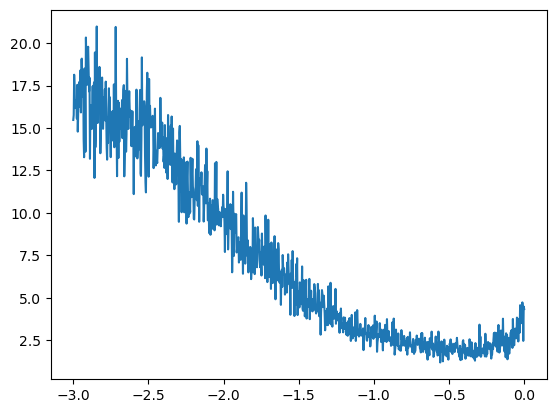

In [54]:
#import os    
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#plt.plot(lri,lossi)

In [47]:
#logits.max(1) #What is predicting

torch.return_types.max(
values=tensor([ 7.1186,  9.2330,  7.4602,  6.8703,  9.7745,  5.0888,  9.1909,  8.4568,
        13.6887, 13.4177,  9.4815,  7.8784, 13.2248,  9.4815,  7.5629,  9.1909,
         8.8562,  9.3250,  4.8949, 11.7279,  7.2558,  6.6266,  8.4072,  7.7619,
         9.1329,  7.3743,  7.8086,  3.5040,  9.8403,  6.7603,  8.1651,  7.0583],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13,  6, 18, 18,  9, 22, 18,  9,  0,  4,  5,  5,  4,  5, 22, 22, 24,
        12, 22,  6,  4,  6, 12, 12, 21, 12,  5, 14, 23, 12,  6]))

In [48]:
#Y

tensor([ 7, 18, 15,  ..., 10, 18,  0])

In [62]:
# Looking at total loss and not just the batches of 32
emb = C[X]
h= torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss
# We have already surpassed effectiveness of Bigram

tensor(0.3810, grad_fn=<NllLossBackward0>)

### training split, dev/validation split, test split

In [63]:
# 80%, 10%, 10%
# training for parameters
# validation for hyperparameters (hyperparameters are for example number of neurons/no. of embed) (hidden)
# test for final loss

In [64]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([4376, 3]) torch.Size([4376])
torch.Size([573, 3]) torch.Size([573])
torch.Size([546, 3]) torch.Size([546])


In [65]:
len(words)

397

In [66]:
n1

317

In [67]:
n2

357

#### Now using only the training Xtr for training

In [101]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([4376, 3]), torch.Size([4376]))

In [102]:
# To not hardcode anything embedded related : 
num_embed = 2
feeded = block_size * num_embed
feeded

6

In [103]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((lenMap, num_embed), generator=g) #You may scale up from 2 embeddings to 10 # Change eveything else accordingly
W1 = torch.randn((feeded, 200), generator=g) #Scaled up neural net 100 -> 200
b1 = torch.randn(200, generator=g) #Scaled up neural net
W2 = torch.randn((200, lenMap), generator=g)
b2 = torch.randn(lenMap, generator=g)
parameters = [C, W1, b1, W2, b2]

In [104]:
sum(p.nelement() for p in parameters) # number of parameters in total

6678

In [105]:
for p in parameters:
  p.requires_grad = True

In [106]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [107]:
for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, feeded) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [108]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, feeded) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(0.4211, grad_fn=<NllLossBackward0>)

In [109]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, feeded) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(0.4390, grad_fn=<NllLossBackward0>)

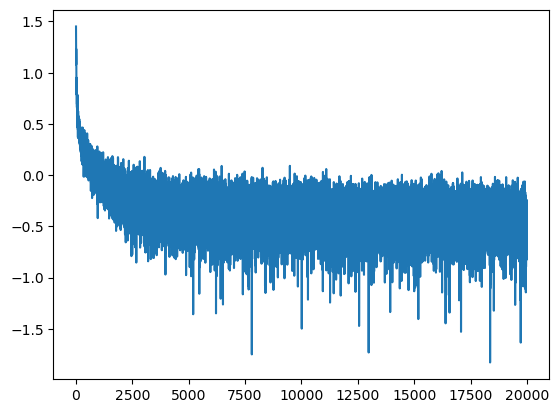

In [111]:
plt.plot(stepi, lossi)

#### Embedding locations for our characters!


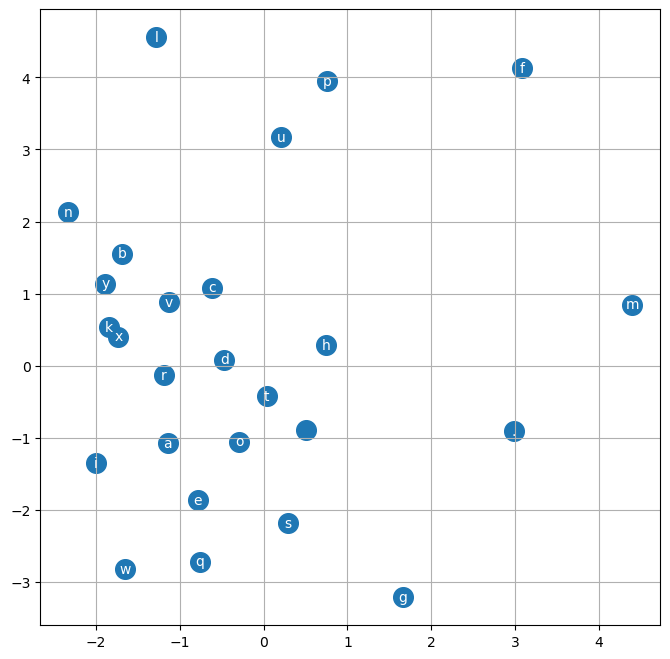

In [110]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200) #X-coord and Y-coord which are the columns of C
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white') #Include text of the char
plt.grid('minor')

# For example, you may see all your vowels clustered together, so your model may see them as interchangeable
# Above is true when only 2 dimensional! If you change embed to 10, we cannot visualize that shit

### Sampling from our model

In [112]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

dra.
flameguard.
eclipsehawk.
specterraven.
crystalphon.
ephon.
sylvanserpent.
flamesphinx.
nightshade hydra.
flamewraith.
nebulagriffin.
sylvanminara.
flameguard.
stormserpent.
quicksilverfenrir.
vortexwraith.
crystal leviathan.
specterwraith.
flameguard.
dra.
